In [2]:
import pint
import xarray as xr
from dask.distributed import Client
from seapopym.configuration.no_transport.parameter import ForcingParameters
from seapopym.configuration.parameters.parameter_forcing import ForcingUnit
from seapopym.standard.units import StandardUnitsLabels
from seapopym_optimization.taylor_diagram import ModTaylorDiagram, generate_mod_taylor_diagram

from seapopym_optimization import (
    FunctionalGroupOptimizeNoTransport,
    GeneticAlgorithm,
    GeneticAlgorithmParameters,
    NoTransportCostFunction,
    Observation,
    Parameter,
    constraint,
)

# Optimization with 3 stations

## Load forcing


In [3]:
latitude_bats = 31.6
longitude_bats = -64.2

Load forcing.


In [4]:
time_start, time_end = "2000-01-01", "2022-01-01"

data = xr.open_dataset("../../1_data_processing/1_1_Forcing/products/Bats_cmems.zarr", engine="zarr")
data["T"].attrs["units"] = StandardUnitsLabels.temperature.units
data.time.attrs["axis"] = "T"
data = data.sel(time=slice(time_start, time_end))
_ = data.load()

cafe_npp = xr.open_dataset("../../1_data_processing/1_1_Forcing/products/Bats_cafe.zarr", engine="zarr")
cafe_npp = cafe_npp.sel(time=slice(time_start, time_end))
cafe_npp = cafe_npp.dropna("time", how="all")
cafe_npp = cafe_npp.resample(time="D").interpolate("linear")
cafe_npp.time.attrs["axis"] = "T"
_ = cafe_npp.load()

Load observations.

First I multiply the observations by the epipelagic layer depth to have a biomass in m2 rather than m3.


In [5]:
def update_layer(data: xr.DataArray, epipelagic_size):
    """Multiply biomass density of observation by the 150m which is the average epipelagic layer depth."""
    data = data.pint.quantify() * epipelagic_size
    layer_attrs = data["layer"].attrs
    data = data.assign_coords({"layer": [1]})
    data["layer"].attrs = layer_attrs
    return data


epipelagic_size = data.pelagic_layer_depth.sel(depth=1).drop_vars("depth") * pint.application_registry("meter")

obs_bats = xr.open_dataset("../../1_data_processing/1_1_Forcing/products/Bats_climato.zarr", engine="zarr")
obs_bats = update_layer(obs_bats, epipelagic_size.sel(latitude=latitude_bats, longitude=longitude_bats))
obs_bats["day"] = obs_bats["day"] + obs_bats["day_trend"]
obs_bats["night"] = obs_bats["night"] + obs_bats["night_trend"]
obs_bats = Observation(obs_bats)

observations = [obs_bats]

Create structure for SeapoPym simulation.


In [6]:
forcing_parameters = ForcingParameters(
    temperature=ForcingUnit(forcing=data["T"], resolution=1 / 12, timestep=1),
    primary_production=ForcingUnit(forcing=cafe_npp["CAFE"], resolution=1 / 12, timestep=1),
)

2024-12-18 14:21:30,307 :: Seapodym ::  WARNING ::
|	CAFE unit is milligram / day / meter ** 2, it will be converted to kilogram / day / meter ** 2.



## Setup the parameters and the cost function


In [7]:
functional_groups = [
    FunctionalGroupOptimizeNoTransport(
        name="D1N1",
        day_layer=1,
        night_layer=1,
        energy_coefficient=Parameter("D1N1_energy_coefficient", 0.05, 0.8),
        # tr_rate=Parameter("D1N1_tr_rate", -1, 0),
        # tr_max=Parameter("D1N1_tr_max", 0, 50),
        tr_rate=-0.11,
        tr_max=10.38,
        inv_lambda_rate=Parameter("D1N1_inv_lambda_rate", 0, 0.2),
        inv_lambda_max=Parameter("D1N1_inv_lambda_max", 0, 500),
    ),
    FunctionalGroupOptimizeNoTransport(
        name="D2N1",
        day_layer=2,
        night_layer=1,
        energy_coefficient=Parameter("D2N1_energy_coefficient", 0.05, 0.8),
        # tr_rate=Parameter("D2N1_tr_rate", -1, 0),
        # tr_max=Parameter("D2N1_tr_max", 0, 50),
        tr_rate=-0.11,
        tr_max=10.38,
        inv_lambda_rate=Parameter("D2N1_inv_lambda_rate", 0, 0.2),
        inv_lambda_max=Parameter("D2N1_inv_lambda_max", 0, 500),
    ),
]

In [8]:
cost_function = NoTransportCostFunction(
    functional_groups=functional_groups,
    forcing_parameters=forcing_parameters,
    observations=observations,
)

Set the genetic algorithm meta parameters.


In [9]:
genetic_algo_parameters = GeneticAlgorithmParameters(
    MUTPB=0.1,
    INDPB=0.2,
    ETA=5,
    CXPB=0.8,
    NGEN=10,
    POP_SIZE=400,
    cost_function_weight=(-1,),
)

Add a constraint to limit the total of energy transfert coefficient to 100%.


In [10]:
constraint_energy = constraint.ConstraintNoTransportEnergyCoefficient(
    parameters_name=["D1N1_energy_coefficient", "D2N1_energy_coefficient"],
    min_energy_coef_value=0,
    max_energy_coef_value=1,
)

Finaly, create the Genetic Algorithm.


In [11]:
client = Client()
genetic_algo = GeneticAlgorithm(
    cost_function=cost_function,
    parameter_genetic_algorithm=genetic_algo_parameters,
    constraint=[constraint_energy],
    client=client,
)

/Users/ash/Documents/Workspaces/PhD/Seapopym-optimisation/.venv/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 54050 instead
  warnings.warn(


And watch the magic on the Dask dashboard :


In [11]:
genetic_algo.client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:50396,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:50407,Total threads: 2
Dashboard: http://127.0.0.1:50409/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:50399,


## Run the optimization


In [12]:
viewer = genetic_algo.optimize()

,mean,std,min,max,valid,from_previous_generation
generation,,,,,,
0,290.842661,675.018258,0.049918,5876.683584,274,0.000000
1,91.685567,314.162977,0.045443,3621.715832,367,0.226158
2,7.751368,25.244265,0.045443,318.825181,389,0.241645
3,3.452637,23.340490,0.044906,284.351216,398,0.148241
4,1.022252,15.124043,0.043763,298.821401,391,0.173913
5,0.334375,1.469951,0.043282,20.231514,390,0.169231
6,0.803961,5.668634,0.043295,85.209260,396,0.143939
7,4.240238,73.352769,0.043096,1443.167099,388,0.221649
8,0.927540,10.323575,0.043342,200.251441,391,0.207161


## Plot the results


In [13]:
viewer.stats

,mean,std,min,max,valid,from_previous_generation
generation,,,,,,
0,290.842661,675.018258,0.049918,5876.683584,274,0.000000
1,91.685567,314.162977,0.045443,3621.715832,367,0.226158
2,7.751368,25.244265,0.045443,318.825181,389,0.241645
3,3.452637,23.340490,0.044906,284.351216,398,0.148241
4,1.022252,15.124043,0.043763,298.821401,391,0.173913
5,0.334375,1.469951,0.043282,20.231514,390,0.169231
6,0.803961,5.668634,0.043295,85.209260,396,0.143939
7,4.240238,73.352769,0.043096,1443.167099,388,0.221649
8,0.927540,10.323575,0.043342,200.251441,391,0.207161


In [14]:
viewer.logbook

D1N1_energy_coefficient  \
generation previous_generation individual                            
0          False               0                          0.594151   
                               1                          0.439672   
                               2                          0.485287   
                               3                          0.756660   
                               4                          0.502125   
...                                                            ...   
10         True                388                        0.173445   
                               394                        0.750347   
                               395                        0.312062   
                               398                        0.331628   
                               399                        0.340131   

                                           D1N1_inv_lambda_max  \
generation previous_generation individual                        
0          False               0                    350.934211   
                               1                    429.599579   
                               2                    321.773673   
                               3                     10.840195   
                               4                     99.085382   
...                                                        ...   
10         True                388                   39.910456   
                               394                    9.012381   
                               395                    9.012381   
                               398                   89.304830   
                               399                    5.178187   

                                           D1N1_inv_lambda_rate  \
generation previous_generation individual                         
0          False               0                       0.179877   
                               1                       0.135151   
                               2                       0.034049   
                               3                       0.063626   
                               4                       0.162683   
...                                                         ...   
10         True                388                     0.131032   
                               394                     0.124076   
                               395                     0.087846   
                               398                     0.172461   
                               399                     0.085236   

                                           D2N1_energy_coefficient  \
generation previous_generation individual                            
0          False               0                          0.689706   
                               1                          0.548043   
                               2                          0.514293   
                               3                          0.209180   
                               4                          0.253047   
...                                                            ...   
10         True                388                        0.248437   
                               394                        0.084385   
                               395                        0.402310   
                               398                        0.136937   
                               399                        0.106662   

                                           D2N1_inv_lambda_max  \
generation previous_generation individual                        
0          False               0                    103.996349   
                               1                     11.786150   
                               2                    379.308866   
                               3                     85.643518   
                               4                    148.246365   
...                         

In [15]:
viewer.hall_of_fame

D1N1_energy_coefficient  D1N1_inv_lambda_max  \
generation individual                                                 
10         225                        0.098583            38.836539   
           109                        0.098583            38.836539   
           173                        0.098583            38.836539   
           26                         0.098583            38.836539   
           224                        0.098583            38.836539   
...                                        ...                  ...   
0          224                        0.499347           318.463452   
           2                          0.485287           321.773673   
1          297                        0.695576           490.666579   
0          270                        0.356683           417.361260   
           64                         0.742577           464.873081   

                       D1N1_inv_lambda_rate  D2N1_energy_coefficient  \
generation individual                                                  
10         225                     0.063626                 0.248437   
           109                     0.063626                 0.187074   
           173                     0.063626                 0.163137   
           26                      0.063626                 0.187074   
           224                     0.063626                 0.187074   
...                                     ...                      ...   
0          224                     0.000911                 0.051681   
           2                       0.034049                 0.514293   
1          297                     0.034609                 0.272844   
0          270                     0.015713                 0.641483   
           64                      0.022951                 0.088552   

                       D2N1_inv_lambda_max  D2N1_inv_lambda_rate      fitness  
generation individual                                                          
10         225                   42.373175              0.159205     0.042392  
           109                   53.026963              0.159205     0.042424  
           173                   81.137740              0.170851     0.042459  
           26                    81.137740              0.170851     0.042658  
           224                   81.137740              0.170851     0.042658  
...                                    ...                   ...          ...  
0          224                  129.529050              0.072494  3178.942114  
           2                    379.308866              0.017764  3338.134349  
1          297                   99.993183              0.070014  3621.715832  
0          270                  446.662074              0.037744  4543.729159  
           64                   334.442908              0.129763  5876.683584  

[3415 rows x 7 columns]

In [16]:
viewer.fitness_evolution()

In [17]:
viewer.box_plot(3)

In [18]:
fig = viewer.parallel_coordinates(500, unselected_opacity=0)
fig.update_layout(width=1000, height=700)

# Generate plots at each station


In [12]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from seapopym_optimization import wrapper

In [20]:
best_individual = cost_function.functional_groups.generate_matrix(viewer.hall_of_fame.iloc[0])
print(f"Best individual: {best_individual}")

Best individual: [[ 1.          1.          0.09858324 10.38       -0.11       38.83653907
   0.0636258 ]
 [ 2.          1.          0.24843736 10.38       -0.11       42.3731752
   0.15920529]]


In [13]:
# best_individual = [
#     [1.0, 1.0, 0.09858324, 10.38, -0.11, 38.83653907, 0.0636258],
#     [2.0, 1.0, 0.24843736, 10.38, -0.11, 42.3731752, 0.15920529],
# ]

In [14]:
model_print = wrapper.model_generator_no_transport(
    forcing_parameters=forcing_parameters,
    fg_parameters=wrapper.FunctionalGroupGeneratorNoTransport(
        best_individual,
        ["D1N1", "D2N1"],
    ),
)

model_print.run()
biomass_print = model_print.export_biomass()

In [15]:
def plot_comparison_to_station(
    obs_1: pd.Series,
    model_1: pd.Series,
    obs_2: pd.Series,
    model_2: pd.Series,
    station_name: str,
    subplot_titles: tuple = ("D1N1", "D2N1"),
    *,
    obs_as_marker: bool = False,
):
    fig = make_subplots(
        rows=2,
        cols=1,
        subplot_titles=subplot_titles,
        shared_xaxes=True,
        x_title="Time",
        y_title="Biomass (g/m2)",
        vertical_spacing=0.1,
    )

    if obs_as_marker:
        additional_param = {"mode": "markers", "marker": {"symbol": "cross", "size": 4}}
    else:
        additional_param = {"mode": "lines"}

    fig.add_trace(
        go.Scatter(x=obs_1.index, y=obs_1, name=f"Observation {subplot_titles[0]}", **additional_param), row=1, col=1
    )
    fig.add_trace(go.Scatter(x=model_1.index, y=model_1, name=f"Model {subplot_titles[0]}"), row=1, col=1)

    fig.add_trace(
        go.Scatter(x=obs_2.index, y=obs_2, name=f"Observation {subplot_titles[1]}", **additional_param), row=2, col=1
    )
    fig.add_trace(go.Scatter(x=model_2.index, y=model_2, name=f"Model {subplot_titles[1]}"), row=2, col=1)

    fig.update_layout(title=f"{station_name} Station", width=1000, height=700)
    return fig


def clean_series(series):
    return series.pint.quantify().pint.to("g/m2").pint.dequantify().to_series().dropna()

## BATS


In [16]:
biomass_bats_plot_d1n1 = clean_series(
    biomass_print.sel(latitude=latitude_bats, longitude=longitude_bats, functional_group=0)
)
biomass_bats_plot_d2n1 = clean_series(
    biomass_print.sel(latitude=latitude_bats, longitude=longitude_bats, functional_group=1)
)

obs_bats_plot_d1n1 = clean_series(obs_bats.observation.day.isel(latitude=0, longitude=0, layer=0))

obs_bats_plot_d2n1 = clean_series(
    (obs_bats.observation.night.pint.quantify() - obs_bats.observation.day.pint.quantify()).isel(
        latitude=0, longitude=0, layer=0
    )
)


plot_comparison_to_station(
    obs_bats_plot_d1n1, biomass_bats_plot_d1n1, obs_bats_plot_d2n1, biomass_bats_plot_d2n1, "BATS"
)

In [17]:
biomass_bats_plot_d1n1 = clean_series(
    biomass_print.sel(latitude=latitude_bats, longitude=longitude_bats, functional_group=0)
)
biomass_bats_plot_d2n1 = clean_series(
    biomass_print.sel(latitude=latitude_bats, longitude=longitude_bats, functional_group=1)
)

obs_bats_plot_d1n1 = clean_series(obs_bats.observation.day.isel(latitude=0, longitude=0, layer=0))

obs_bats_plot_d2n1 = clean_series(
    (obs_bats.observation.night.pint.quantify() - obs_bats.observation.day.pint.quantify()).isel(
        latitude=0, longitude=0, layer=0
    )
)


plot_comparison_to_station(
    obs_bats_plot_d1n1.resample("ME").mean(),
    biomass_bats_plot_d1n1.resample("ME").mean(),
    obs_bats_plot_d2n1.resample("ME").mean(),
    biomass_bats_plot_d2n1.resample("ME").mean(),
    "Monthly : BATS",
)

## Taylor diagram


correlation [0.010390677561246401, 0.19088876034925764]
norm STD [0.9023260150961824, 0.6744673479210782]
bias [-0.007952598948833422, -0.3471572052667883]
NRMSE [1.339940550981042, 1.09426218591811]
name ['BATS D1N1', 'BATS D2N1']


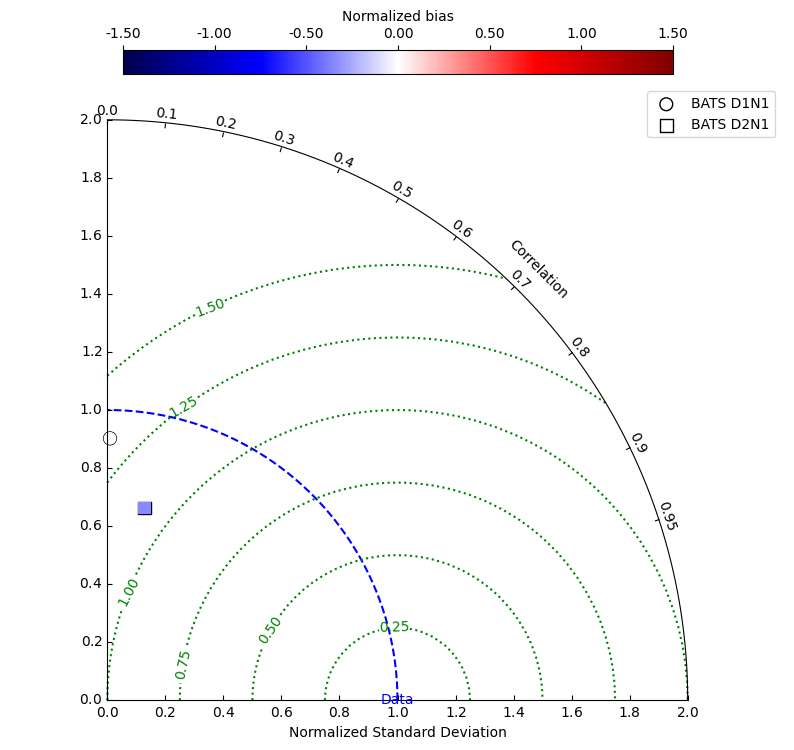

In [18]:
diagram = ModTaylorDiagram()

all_model = [
    biomass_bats_plot_d1n1,
    biomass_bats_plot_d2n1,
]
all_obs = [
    obs_bats_plot_d1n1,
    obs_bats_plot_d2n1,
]

all_names = ["BATS D1N1", "BATS D2N1"]

for model, obs, name in zip(all_model, all_obs, all_names):
    diagram = generate_mod_taylor_diagram(diagram, obs=obs, model=model[obs.index], name=name)

diagram.plot()

correlation [0.025832210386030615, 0.25602973179989735]
norm STD [0.9580238757269602, 0.7186031019221606]
bias [0.0013307721437131517, -0.4053232666312799]
NRMSE [1.3668628306591952, 1.0716449501494145]
name ['BATS D1N1', 'BATS D2N1']


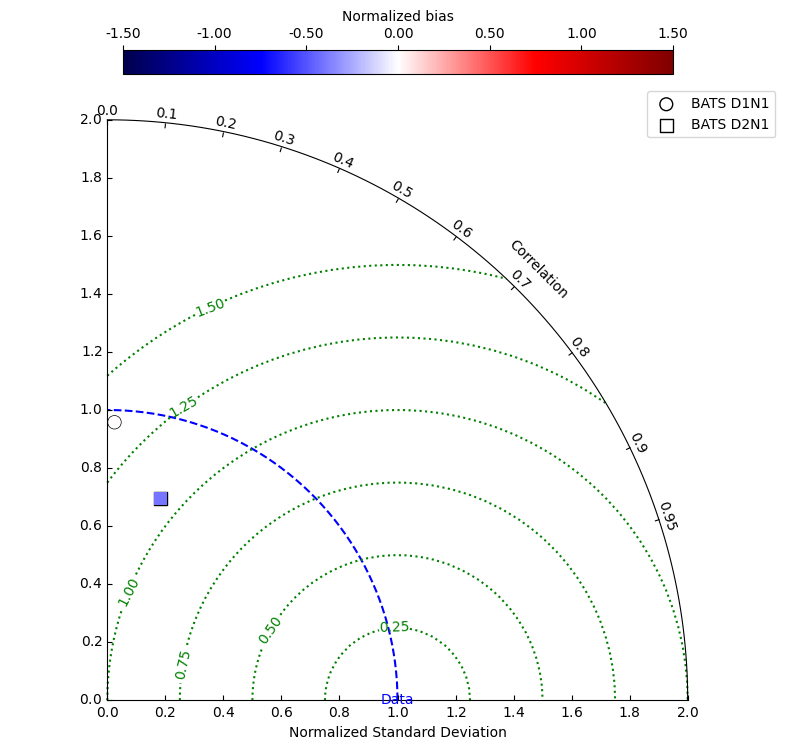

In [19]:
diagram = ModTaylorDiagram()

all_model = [
    biomass_bats_plot_d1n1.resample("ME").mean(),
    biomass_bats_plot_d2n1.resample("ME").mean(),
]
all_obs = [
    obs_bats_plot_d1n1.resample("ME").mean(),
    obs_bats_plot_d2n1.resample("ME").mean(),
]

all_names = ["BATS D1N1", "BATS D2N1"]

for model, obs, name in zip(all_model, all_obs, all_names):
    diagram = generate_mod_taylor_diagram(diagram, obs=obs, model=model[obs.index], name=name)
diagram.plot()